# Description

In [8]:
############# Libaries ###############

import h5py
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import math
import time
import itertools
from itertools import product, zip_longest
import pickle
from tqdm import tqdm, trange
from datetime import date

import sys
import os

In [9]:
add_mask = True             #Add a mask to the data - this mask eliminates data below a threshold (mas_amplitude)
subsection = False           #Looks at a region a sixteenth of the full size
apply_normalizer = True     #Normalizes the data during the processing step
estimate_offset = True      #Adds an offset to the signal that is estimated
multistart_method = False    #Applies a multistart method for each parameter fitting instance

In [10]:
brain_data = scipy.io.loadmat(os.getcwd() + '/MB_References/BLSA_1742_04_MCIAD_m41/NESMA_slice5.mat')
I_raw = brain_data['slice_oi']

if subsection:
    I_raw_x = I_raw.shape[0]//4
    I_raw_y = I_raw.shape[1]//4
    I_raw = I_raw[I_raw_x:2*I_raw_x, I_raw_y:2*I_raw_y, :]

n_vert, n_hori, n_elements_brain = I_raw.shape

t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata = np.linspace(t_increment_brain, (n_elements_brain)*(t_increment_brain), n_elements_brain)

# #This is how we will keep track of all voxels that are called --------------------------------- no iterator for voxels needed
# target_iterator = np.array([item for item in itertools.product(np.arange(0,n_vert,1), np.arange(0,n_hori,1))])

# all pixels with a lower mask amplitude are considered to be free water (i.e. vesicles)
mask_amplitude = 700



if multistart_method:
    num_nultistarts = 10
    ms_upper_bound = [1,60,300] 
else:
    num_multistarts = 1
    ms_upper_bound = [0] 

param_name_list_biX = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']
param_name_list_moX = [r'$c_1$',r'$T_{21}$']

if subsection:
    vert1 = 37
    vert2 = 47
    hori1 = 25
    hori2 = 70
else:
    vert1 = 165             #60     #108
    vert2 = 180            #125     #116
    hori1 = 120            #100      #86
    hori2 = 180            #115      #93

vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

noiseRegion = [vert1,vert2,hori1,hori2]


In [11]:
def G_off_biX(t, con_1, con_2, tau_1, tau_2, offSet): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return function

def G_off_moX(t, con_1, tau_1, offSet): 
    function = con_1*np.exp(-t/tau_1) + offSet
    return function

def G_biX(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_moX(t, con_1, tau_1): 
    function = con_1*np.exp(-t/tau_1)
    return function

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

In [12]:
def mask_data(raw, mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<mask_amplitude] = 0
    return I_masked

def normalize_brain(I_data):
    n_vert, n_hori, n_elem = I_data.shape
    I_normalized = np.zeros(I_data.shape)
    for i_vert in range(n_hori):
        for i_hori in range(n_vert):
            data = I_data[i_vert,i_hori,:]
            if data[0]>0:
                data_normalized = data/(data[0])
            else:
                data_normalized = np.zeros(n_elements_brain)
            I_normalized[i_vert,i_hori,:] = data_normalized
    return I_normalized

def get_param_p0(function, offSet = estimate_offset, sig_init = 1):
    f_name = function.__name__

    if 'biX' in f_name:
        init_p0 = [sig_init*0.2, sig_init*0.8, 20, 80]
    elif 'moX' in f_name:
        init_p0 = [sig_init, 20]
    else:
        raise Exception("Not a valid function: " + f_name)
    
    if 'off' in f_name:
        init_p0.append(1)

    return init_p0

def check_param_order(popt, func):
    #Function to automate the order of parameters if desired
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    
    f_name = func.__name__
    num = 0
    if 'off' in f_name:
        num = -1

    if (popt[-2+num] > popt[-1+num]): #We want by convention to make sure that T21 is <= T22
        for i in range(popt.shape[0]//2):
            p_hold = popt[2*i]
            popt[2*i] = popt[2*i+1]
            popt[2*i+1] = p_hold
    return popt

def get_param_num(function):
    f_name = function.__name__
    num = 0
    if 'off' in f_name:
        num = 1
    if 'biX' in f_name:
        num = num + 4
    elif 'moX' in f_name:
        num = num + 2
    else:
        raise Exception("Not a valid function: " + f_name)

    return num

def get_param_UB(function):
    f_name = function.__name__

    if 'biX' in f_name:
        upper_bound = [0.5,1.2,60,300]
    elif 'moX' in f_name:
        upper_bound = [1.2,300]
    else:
        raise Exception("Not a valid function: " + f_name)
    
    if 'off' in f_name:
        upper_bound.append(np.inf)

    return upper_bound

def get_param_LB(function):
    f_name = function.__name__

    if 'biX' in f_name:
        lower_bound = [0,0,0,0]
    elif 'moX' in f_name:
        lower_bound = [0,0]
    else:
        raise Exception("Not a valid function: " + f_name)
    
    if 'off' in f_name:
        lower_bound.append(0)

    return lower_bound

def get_error(function):
    f_name = function.__name__

    if 'biX' in f_name:
        error_mat = [0,0,1,1]
    elif 'moX' in f_name:
        error_mat = [0,1]
    else:
        raise Exception("Not a valid function: " + f_name)
    
    if 'off' in f_name:
        error_mat.append(0)

    return error_mat

def calculate_brain_SNR(raw, region):
    #calculates the SNR of the brain using a homogenous region fed into the 
    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    regionZero_mean = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:] #last three points across the entire sampled region
    regionEnd_std = np.std(regionEnd)
    regionEnd_absMean = np.mean(np.abs(regionEnd))

    SNR_region = (regionZero_mean - regionEnd_absMean)/regionEnd_std

    return SNR_region

def calculate_indiv_SNR(sig, est_curve):
    residuals = sig - est_curve
    curve_std = np.max([np.std(residuals), 10**-16])
    return sig[0]/curve_std

In [13]:
def estimate_parameters(data, func, n_initials = num_multistarts):
    #Pick n_initials random initial conditions within the bound, and choose the one giving the lowest model-data mismatch residual

    RSS_hold = 0
    for i in range(n_initials):

        np.random.seed(i) #Only has an effect on the multistart strategy

        init_params = get_param_p0(func, sig_init = data[0])

        temp_upper_bound = get_param_UB(func)
        if not apply_normalizer:
            temp_upper_bound[0] = data[0]*temp_upper_bound[0]
            temp_upper_bound[1] = data[0]*temp_upper_bound[1]
        
        try:
            lower_bound = get_param_LB(func)
            popt, _ = curve_fit(func, tdata, data, bounds = (lower_bound, temp_upper_bound), p0=init_params, max_nfev = 4000)
        except Exception as error:
            popt = get_error(func)
            print("Error in parameter fitting: " + str(error))

        est_curve = func(tdata,*popt)
        RSS_temp = np.sum((est_curve - data)**2)

        # if RSS_temp < RSS_hold:
        best_popt = popt
        RSS_hold = RSS_temp
        
    popt = check_param_order(best_popt, func)
 
    return popt, RSS_hold


def generate_all_estimates(brain_data_3D, func):
    #Generates a comprehensive matrix of all parameter estimates for all param combinations, 
    #noise realizations, SNR values, and lambdas of interest
    
    RSS_list = np.zeros((brain_data_3D.shape[0],brain_data_3D.shape[1]))
    param_list = np.zeros((brain_data_3D.shape[0],brain_data_3D.shape[0],get_param_num(func)))
    SNR_list = np.zeros((brain_data_3D.shape[0],brain_data_3D.shape[1]))

    for ii in trange(brain_data_3D.shape[0]):
        for jj in range(brain_data_3D.shape[1]):

            noise_data = brain_data_3D[ii, jj, :]
            assert(noise_data.shape[0] == n_elements_brain)

            if noise_data[0] == 0:
                param_estimates = get_error(func)
                RSS_estimate = 0
            else:
                param_estimates, RSS_estimate = estimate_parameters(noise_data, func)
                
            param_list[ii,jj,:] = param_estimates
            RSS_list[ii,jj] = RSS_estimate
            SNR_list[ii,jj] = calculate_indiv_SNR(noise_data, func(tdata, *param_estimates))

    return param_list, RSS_list, SNR_list

In [14]:
#### This ensures that the same mask is applied throughout

if add_mask:
    I_masked = mask_data(I_raw, mask_amplitude)
    I_mask_factor = (I_masked!=0)
else:
    I_masked = I_raw
    I_mask_factor = (I_masked!=0)

#### Generate the standard reference

if apply_normalizer:
    stand_ref = normalize_brain(I_masked)
else:
    stand_ref = I_masked

pest_biX_off_params, pest_biX_off_RSS, pest_biX_off_SNR = generate_all_estimates(stand_ref, G_off_biX)

pest_moX_off_params, pest_moX_off_RSS, pest_moX_off_SNR = generate_all_estimates(stand_ref, G_off_moX)



 42%|████▏     | 122/288 [01:19<06:05,  2.20s/it]

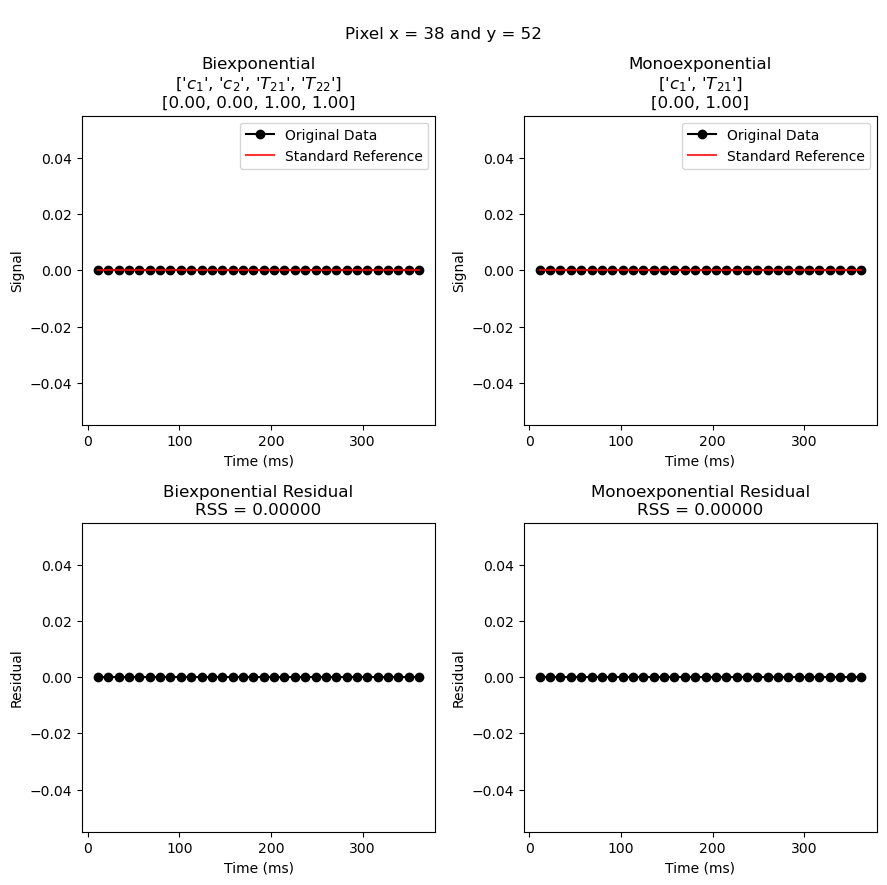

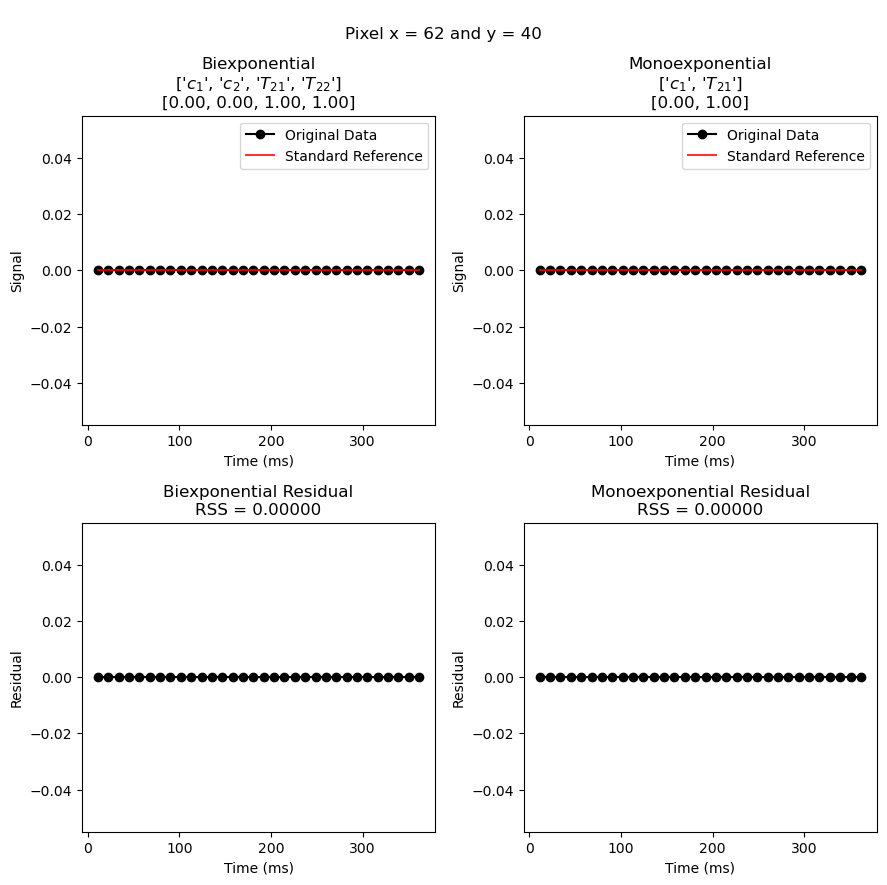

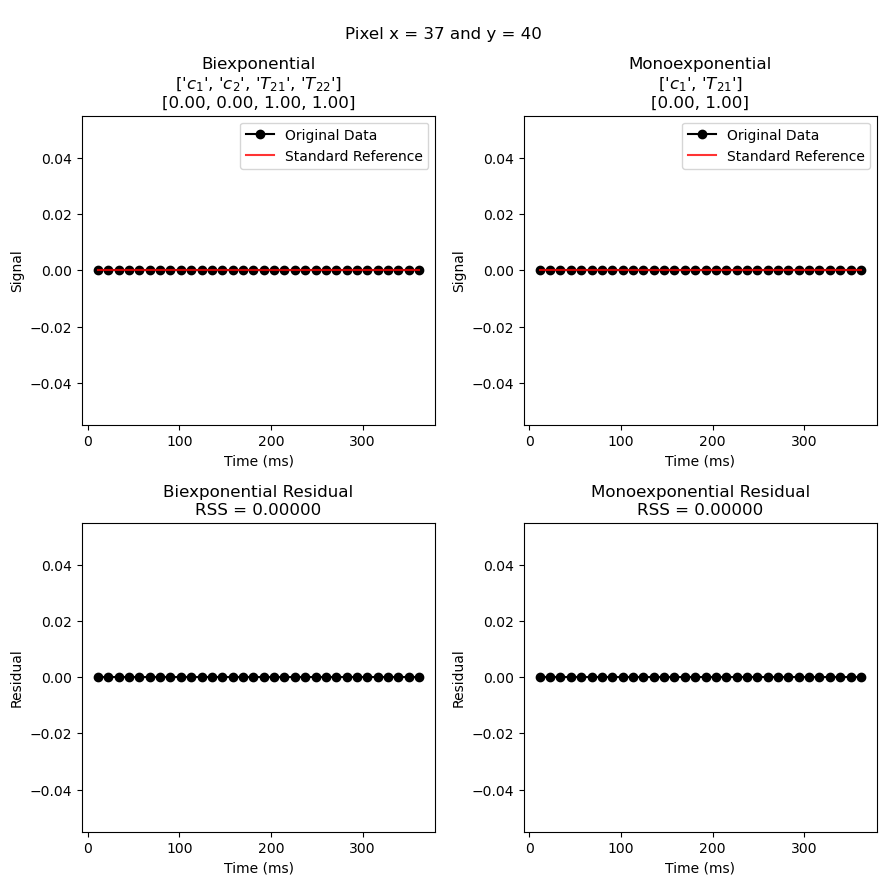

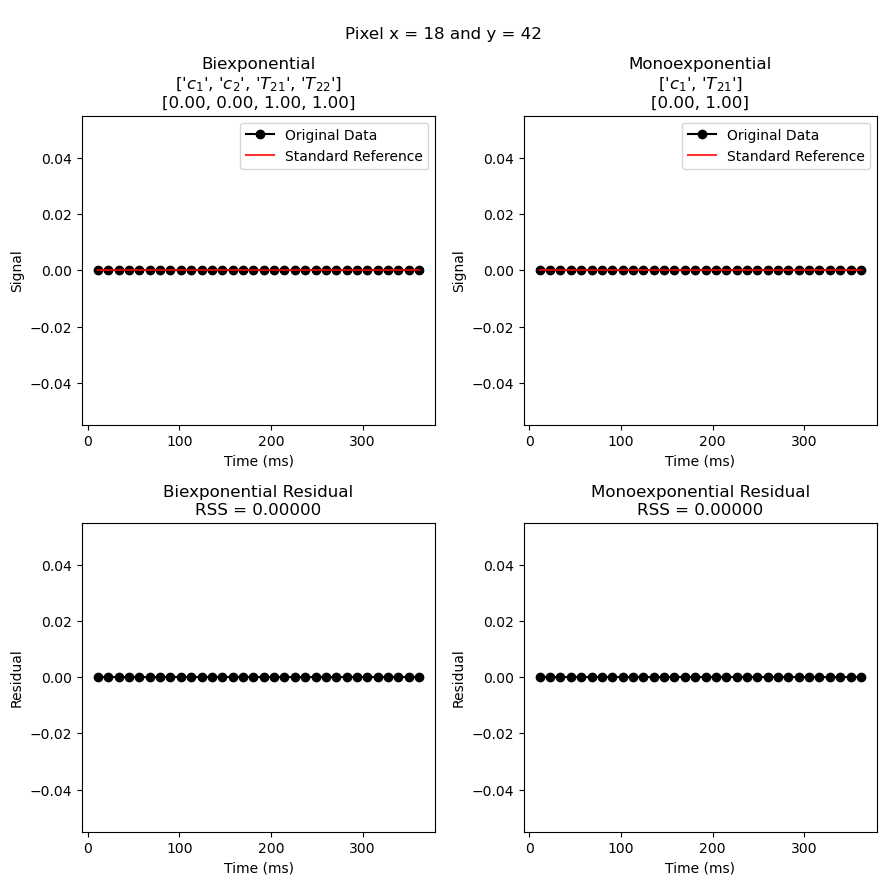

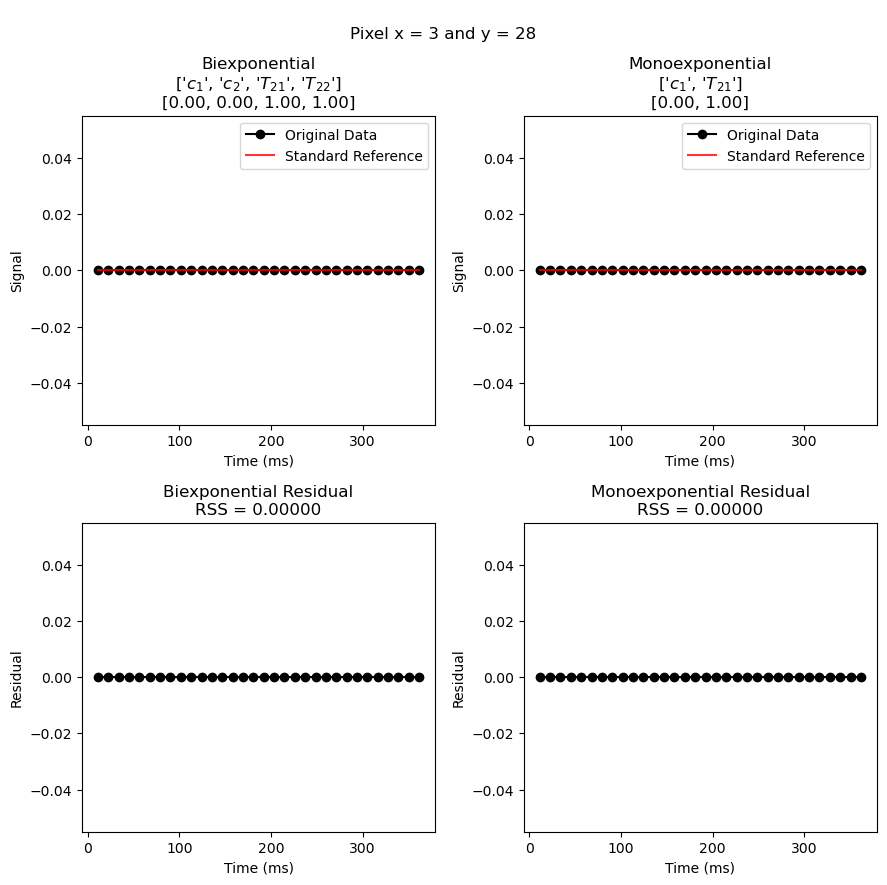

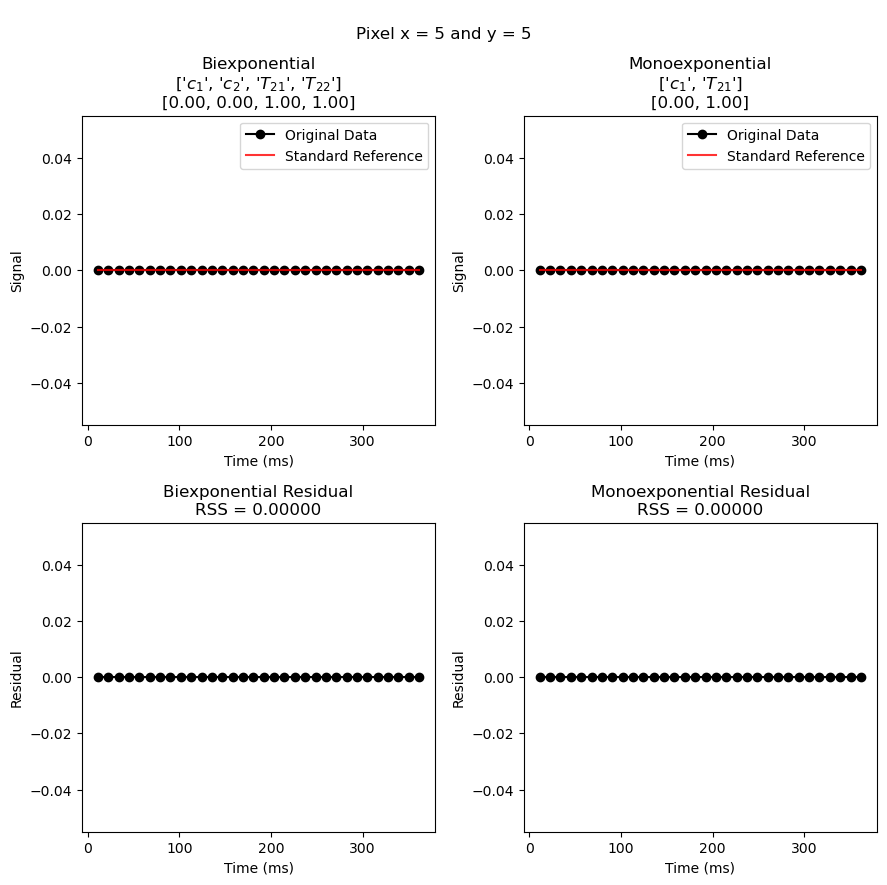

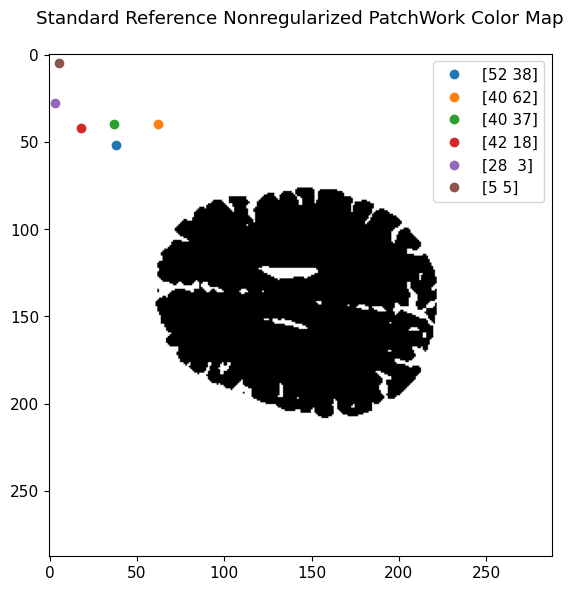

In [ ]:
pixels = np.array([[52,38],[40,62],[40,37],[42,18],[28,3],[5,5]])

for pix in range(pixels.shape[0]):
    pix_x, pix_y = pixels[pix, :]
    fig, ax = plt.subplots(2,2,figsize=(9,9),tight_layout=True)
    plt.suptitle(f"\nPixel x = {pixels[pix,1]} and y = {pixels[pix,0]}")
    ax[0,0].plot(tdata, stand_ref[pix_x,pix_y,:], color = 'k', label = "Original Data", marker = 'o')
    ax[0,0].plot(tdata, G_off_biX(tdata, *pest_biX_off_params[pix_x, pix_y, :]), label = "Standard Reference", alpha = 0.8, ls = "-", color = 'r')
    ax[0,0].set_xlabel('Time (ms)')
    ax[0,0].set_ylabel('Signal')
    ax[0,0].set_title("Biexponential\n" + f"{param_name_list_biX}\n[{pest_biX_off_params[pix_x, pix_y, 0]:.2f}, {pest_biX_off_params[pix_x, pix_y, 1]:.2f}, {pest_biX_off_params[pix_x, pix_y, 2]:.2f}, {pest_biX_off_params[pix_x, pix_y, 3]:.2f}]")
    ax[0,0].legend()

    ax[1,0].plot(tdata, stand_ref[pix_x,pix_y,:] - G_off_biX(tdata, *pest_biX_off_params[pix_x, pix_y, :]), color = 'k', marker = 'o')
    ax[1,0].set_xlabel('Time (ms)')
    ax[1,0].set_ylabel('Residual')
    ax[1,0].set_title(f"Biexponential Residual\nRSS = {pest_biX_off_RSS[pix_x,pix_y]:0.5f}")
    

    ax[0,1].plot(tdata, stand_ref[pix_x,pix_y,:], color = 'k', label = "Original Data", marker = 'o')
    ax[0,1].plot(tdata, G_off_moX(tdata, *pest_moX_off_params[pix_x, pix_y, :]), label = "Standard Reference", alpha = 0.8, ls = "-", color = 'r')
    ax[0,1].set_xlabel('Time (ms)')
    ax[0,1].set_ylabel('Signal')
    ax[0,1].set_title("Monoexponential\n" + f"{param_name_list_moX}\n[{pest_moX_off_params[pix_x, pix_y, 0]:.2f}, {pest_moX_off_params[pix_x, pix_y, 1]:.2f}]")
    ax[0,1].legend()

    ax[1,1].plot(tdata, stand_ref[pix_x,pix_y,:] - G_off_moX(tdata, *pest_moX_off_params[pix_x, pix_y, :]), color = 'k', marker = 'o')
    ax[1,1].set_xlabel('Time (ms)')
    ax[1,1].set_ylabel('Residual')
    ax[1,1].set_title(f"Monoexponential Residual\nRSS = {pest_moX_off_RSS[pix_x,pix_y]:0.5f}")


plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Standard Reference Nonregularized PatchWork Color Map")
imc1 = ax.imshow(1-stand_ref[:,:,0], cmap = 'gray')
for ii in range(pixels.shape[0]):
    ax.plot(pixels[ii,1], pixels[ii,0], marker = 'o', ls = '', label = f'{pixels[ii,:]}')
ax.legend()



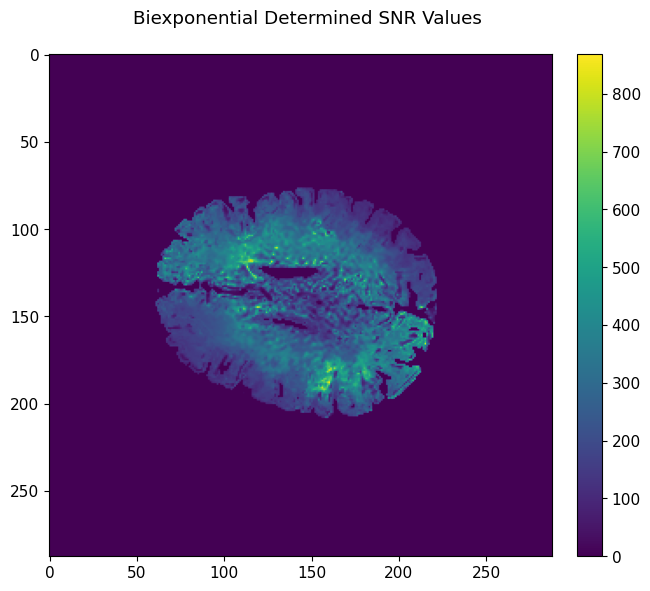

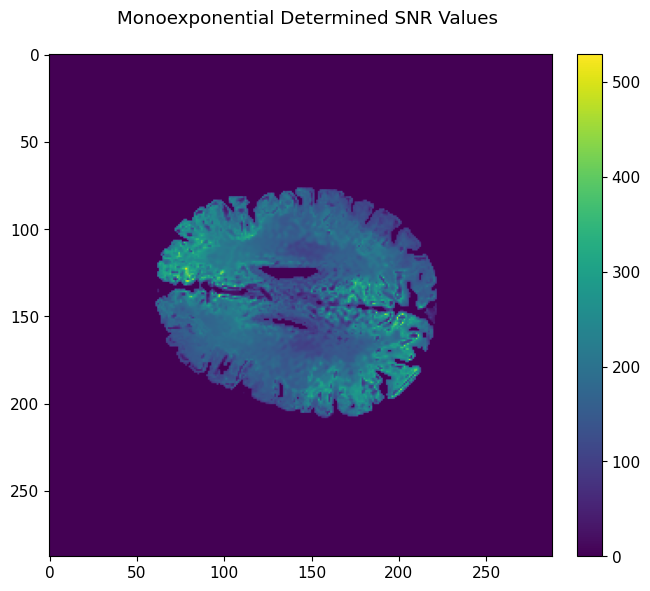

In [ ]:
plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Biexponential Determined SNR Values")
imc1 = ax.imshow(pest_biX_off_SNR)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Monoexponential Determined SNR Values")
imc1 = ax.imshow(pest_moX_off_SNR)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

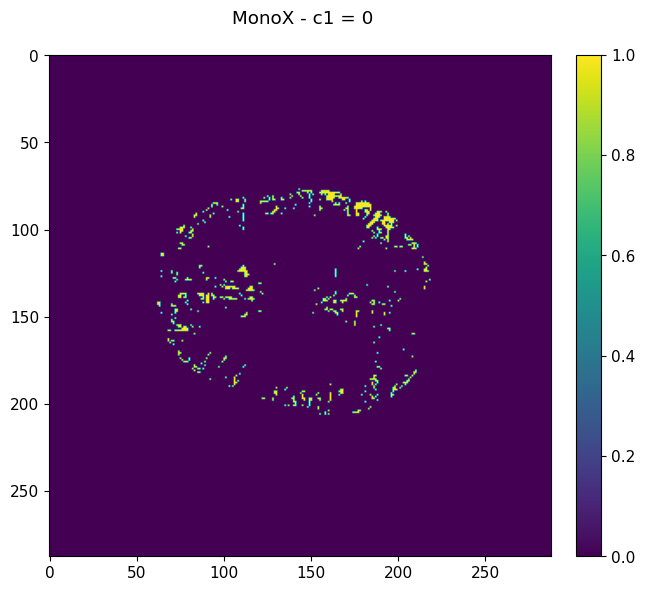

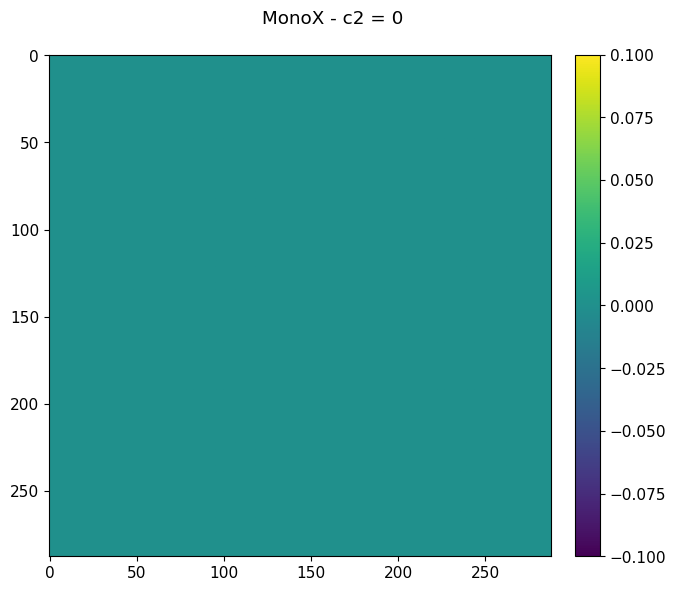

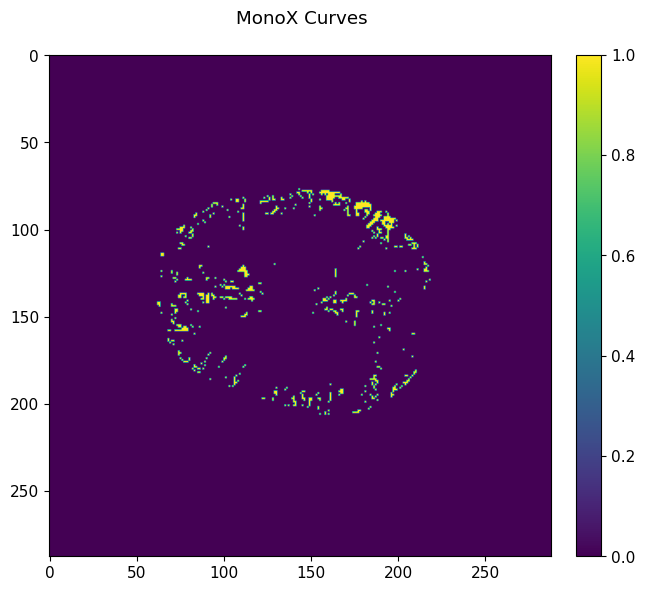

In [ ]:
threshold = 0.001

combo1 = (pest_biX_off_params[:,:,0] < threshold) * (pest_biX_off_params[:,:,1] > threshold)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"MonoX - c1 = 0")
imc1 = ax.imshow(combo1)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

combo2 = (pest_biX_off_params[:,:,1] < threshold) * (pest_biX_off_params[:,:,0] > threshold)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"MonoX - c2 = 0")
imc1 = ax.imshow(combo2)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"MonoX Curves")
imc1 = ax.imshow(combo2+combo1)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

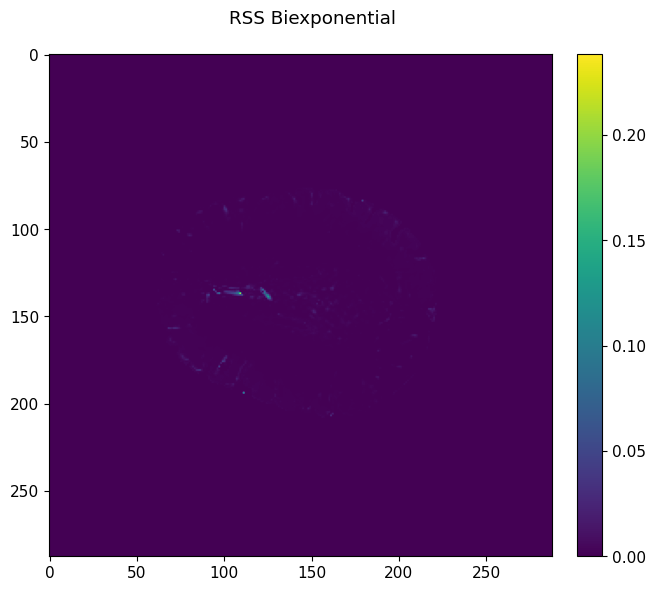

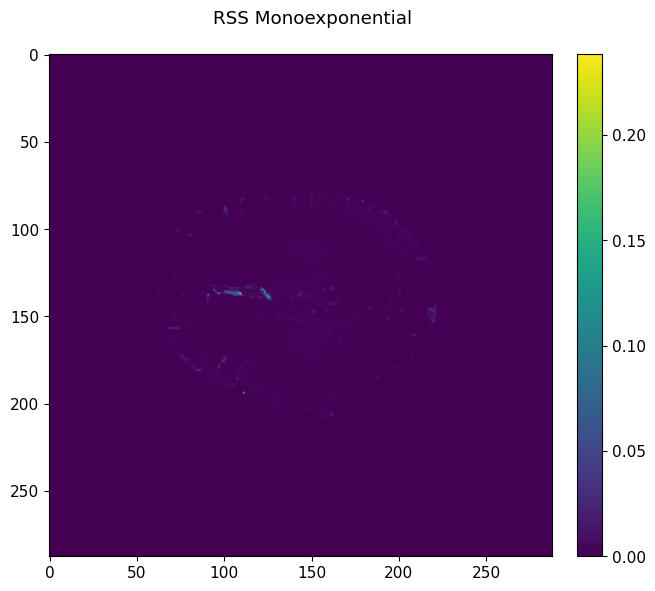

In [ ]:
# RSS results

# plt.rc('font', size  = 11)
# fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
# fig.suptitle(f"RSS Biexponential")
# imc1 = ax.imshow(pest_biX_off_RSS)

# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# plt.rc('font', size  = 11)
# fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
# fig.suptitle(f"RSS Monoexponential")
# imc1 = ax.imshow(pest_moX_off_RSS)

# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

In [ ]:
BIC_2E = 1/tdata.shape[0] * (pest_biX_off_RSS + np.log(tdata.shape[0]) * 5*stand_ref[:,:,0]/pest_biX_off_SNR**2)

BIC_1E = 1/tdata.shape[0] * (pest_moX_off_RSS + np.log(tdata.shape[0]) * 3*stand_ref[:,:,0]/pest_biX_off_SNR**2)

/tmp/ipykernel_3529202/711874676.py:1: RuntimeWarning: invalid value encountered in divide
  BIC_2E = 1/tdata.shape[0] * (pest_biX_off_RSS + np.log(tdata.shape[0]) * 5*stand_ref[:,:,0]/pest_biX_off_SNR**2)
/tmp/ipykernel_3529202/711874676.py:3: RuntimeWarning: invalid value encountered in divide
  BIC_1E = 1/tdata.shape[0] * (pest_moX_off_RSS + np.log(tdata.shape[0]) * 3*stand_ref[:,:,0]/pest_biX_off_SNR**2)


In [ ]:
SNR_SR = calculate_brain_SNR(stand_ref, noiseRegion)

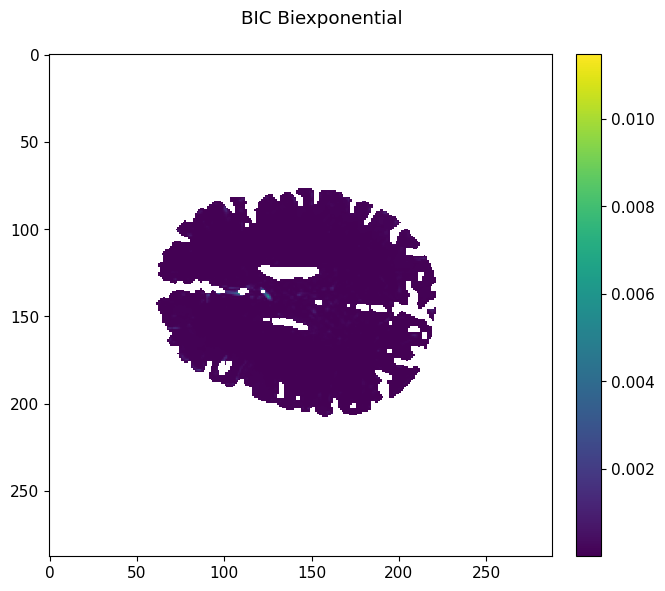

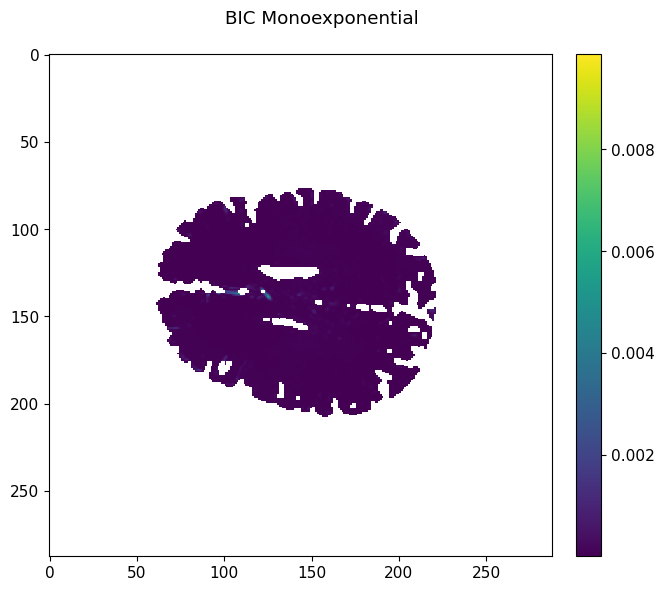

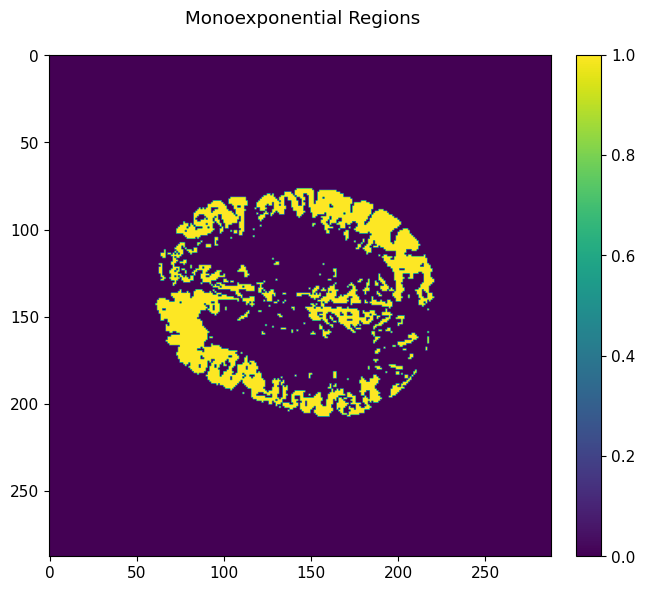

In [ ]:
# plt.rc('font', size  = 11)
# fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
# fig.suptitle(f"BIC Biexponential")
# imc1 = ax.imshow(BIC_2E)

# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# plt.rc('font', size  = 11)
# fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
# fig.suptitle(f"BIC Monoexponential")
# imc1 = ax.imshow(BIC_1E)

# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Monoexponential Regions")
imc1 = ax.imshow(BIC_1E<BIC_2E)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

In [ ]:
biX_off_CN = np.zeros(pest_biX_off_RSS.shape)

for ii in range(pest_biX_off_params.shape[0]):
    for jj in range(pest_biX_off_params.shape[1]):
        biX_off_CN[ii,jj] = np.linalg.cond(J(tdata, *pest_biX_off_params[ii,jj,:]))


In [ ]:
plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Condition Number Plot")
imc1 = ax.imshow(biX_off_CN)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

In [15]:
data_offRemoved =  np.reshape(np.reshape(stand_ref, (-1,32)) - np.reshape(pest_biX_off_params[:,:,-1], (-1, 1)), stand_ref.shape )
print(data_offRemoved.shape)
print(stand_ref.shape)

pest_biX_params, pest_biX_RSS, pest_biX_SNR = generate_all_estimates(data_offRemoved, G_biX)

pest_moX_params, pest_moX_RSS, pest_moX_SNR = generate_all_estimates(data_offRemoved, G_moX)

(288, 288, 32)
(288, 288, 32)


100%|██████████| 288/288 [01:33<00:00,  3.07it/s]


/tmp/ipykernel_3529202/2855239841.py:1: RuntimeWarning: invalid value encountered in divide
  BIC_2E_deOff = 1/tdata.shape[0] * (pest_biX_RSS + np.log(tdata.shape[0]) * 4*stand_ref[:,:,0]/pest_biX_off_SNR**2)
/tmp/ipykernel_3529202/2855239841.py:3: RuntimeWarning: invalid value encountered in divide
  BIC_1E_deOff = 1/tdata.shape[0] * (pest_moX_RSS + np.log(tdata.shape[0]) * 2*stand_ref[:,:,0]/pest_biX_off_SNR**2)


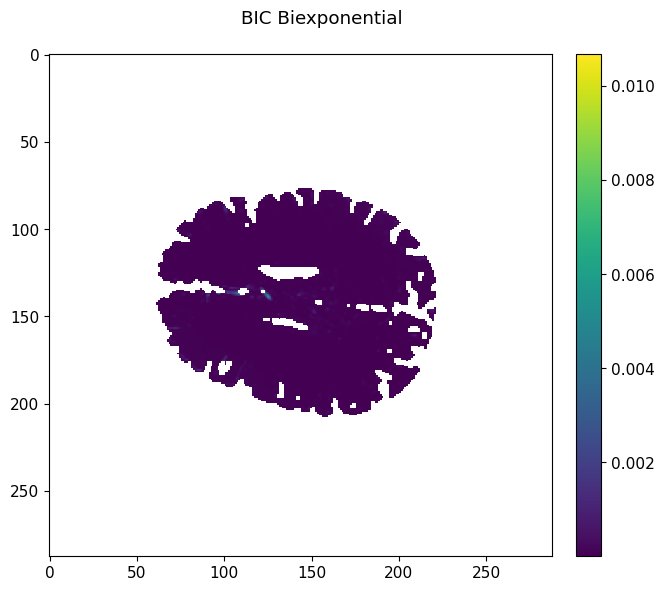

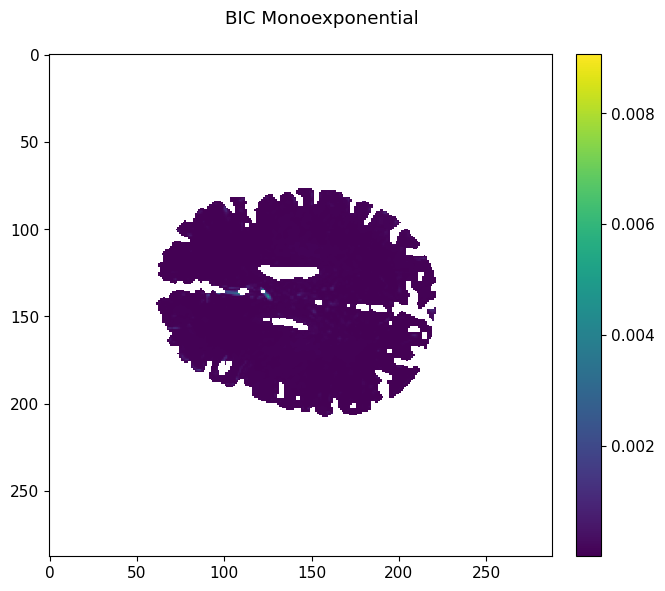

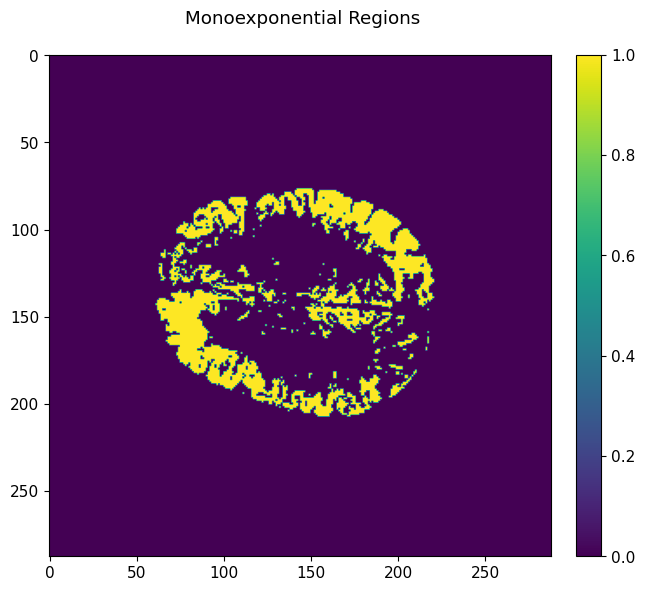

In [16]:
BIC_2E_deOff = 1/tdata.shape[0] * (pest_biX_RSS + np.log(tdata.shape[0]) * 4*stand_ref[:,:,0]/pest_biX_off_SNR**2)

BIC_1E_deOff = 1/tdata.shape[0] * (pest_moX_RSS + np.log(tdata.shape[0]) * 2*stand_ref[:,:,0]/pest_biX_off_SNR**2)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"BIC Biexponential")
imc1 = ax.imshow(BIC_2E_deOff)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"BIC Monoexponential")
imc1 = ax.imshow(BIC_1E_deOff)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Monoexponential Regions")
imc1 = ax.imshow(BIC_1E_deOff<BIC_2E_deOff)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)